<a href="https://colab.research.google.com/github/BeeramVineethReddy/Geno_Intern/blob/master/Copy_of_Trail_6(att_U_Net).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import sys
import random
from skimage.io import imread,imshow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import losses 
from sklearn.model_selection import train_test_split

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input,add, multiply
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint,EarlyStopping
from keras.layers import concatenate, core, Dropout
from keras.models import Model

from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers.core import Lambda
import keras.backend as K

seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

train_ratio = 0.70
validation_ratio = 0.10
test_ratio = 0.20

In [ ]:
x = []; y = []
alpha = 1.2; beta = 0
images = sorted(os.listdir('data/image'))
masks = sorted(os.listdir('data/mask'))
for image in images:
  img = cv2.imread('data/image/' + image)
  img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
  x.append(img)
  x.append(cv2.flip(img, 0))
  x.append(cv2.flip(img, -1))
  x.append(cv2.flip(img, 1))

  msk = cv2.imread('data/mask/'+ image[:-4] + '_anno.png',0).reshape(256,256,1)
  y.append(msk)
  y.append(cv2.flip(msk, 0).reshape(256,256,1))
  y.append(cv2.flip(msk, -1).reshape(256,256,1))
  y.append(cv2.flip(msk, 1).reshape(256,256,1))
x = np.asarray(x)/255; y = np.asarray(y)/255

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1 - train_ratio, random_state = 42, shuffle = True)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = 42, shuffle = True) 
print('Data Split!')
print(len(x_train),len(x_test), len(x_valid))
print(x_train[0].shape, y_train[0].shape)

Data Split!
1343 385 192
(256, 256, 3) (256, 256, 1)


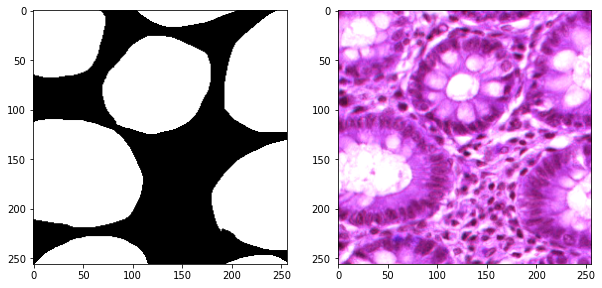

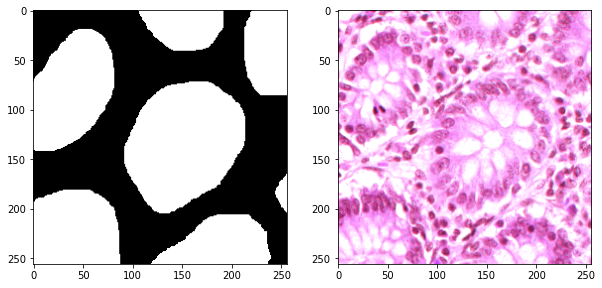

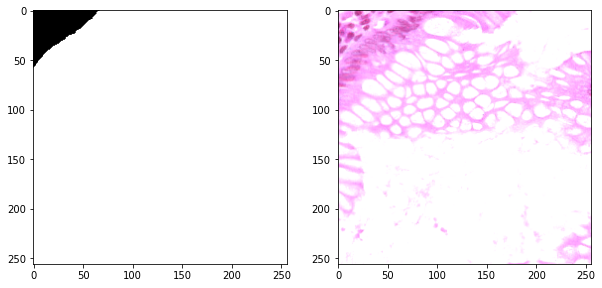

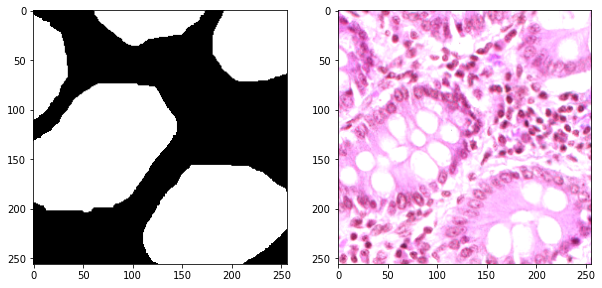

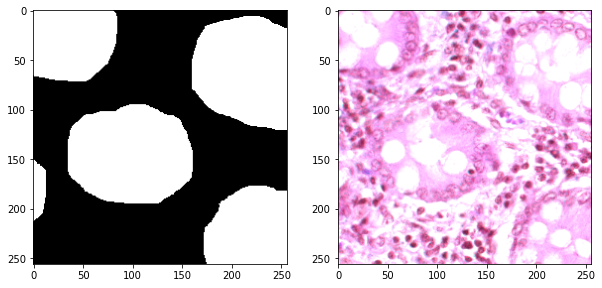

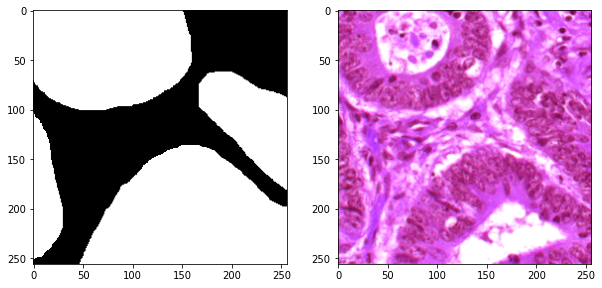

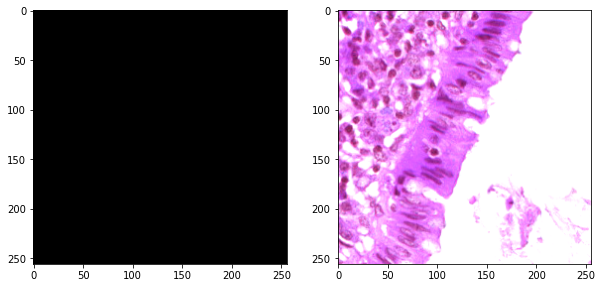

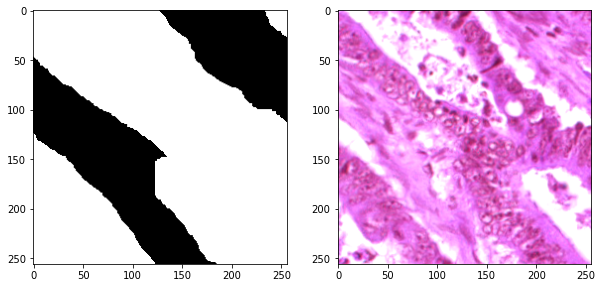

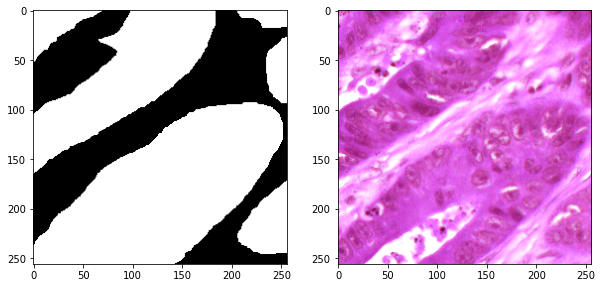

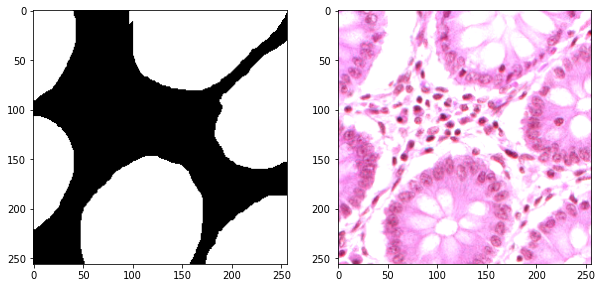

In [ ]:
for i in range(10,20):
  fig=plt.figure(figsize=(10,10))
  a=fig.add_subplot(1,2,1)
  a.imshow(y_train[i].reshape(256,256),cmap="gray")
  a=fig.add_subplot(1,2,2)  
  a.imshow(x_train[i])

In [ ]:
import cv2 
import time
import os
import h5py

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Activation, add, multiply, Lambda
from keras.layers import AveragePooling2D, average, UpSampling2D, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.initializers import glorot_normal, random_normal, random_uniform
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from keras import backend as K
from keras.layers.normalization import BatchNormalization 
from keras.applications import VGG19, densenet
from keras.models import load_model

import numpy as np
import tensorflow as tf 
import losses 
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc, precision_recall_curve # roc curve tools
from sklearn.model_selection import train_test_split

In [ ]:


kinit = 'glorot_normal'
def expend_as(tensor, rep,name):
	my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
	return my_repeat
  
def AttnGatingBlock(x, g, inter_shape, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x 
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''
    
    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

def UnetConv2D(input, outdim, is_batchnorm, name):
   #x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
    x = Conv2D(outdim, 3, strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)

    if is_batchnorm:
        x =BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu',name=name + '_1_act')(x)

    #x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
    x = Conv2D(outdim, 3, strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)

    if is_batchnorm:
        x = BatchNormalization(name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_act')(x)
    return x


def UnetGatingSignal(input, is_batchnorm, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=kinit, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name = name + '_act')(x)
    return x

# plain old attention gates in u-net, NO multi-input, NO deep supervision
def attn_unet(opt,input_size):   
    inputs = Input(shape=input_size)
    conv1 = UnetConv2D(inputs, 32, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = UnetConv2D(pool1, 32, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = UnetConv2D(pool2, 64, is_batchnorm=True, name='conv3')
    #conv3 = Dropout(0.2,name='drop_conv3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = UnetConv2D(pool3, 64, is_batchnorm=True, name='conv4')
    #conv4 = Dropout(0.2, name='drop_conv4')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    center = UnetConv2D(pool4, 128, is_batchnorm=True, name='center')
    
    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, 128, '_1')
    up1 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(center), attn1], name='up1')
    
    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, 64, '_2')
    up2 = concatenate([Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up1), attn2], name='up2')

    g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, 32, '_3')
    up3 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up2), attn3], name='up3')

    up4 = concatenate([Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up3), conv1], name='up4')
    out = Conv2D(1, (1, 1), activation='sigmoid',  kernel_initializer=kinit, name='final')(up4)
    
    model = Model(inputs=[inputs], outputs=[out])
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(num_classes=2), losses.dsc,losses.tp,losses.tn])
    #model.compile(optimizer=opt, loss=lossfxn, metrics=[losses.dsc,losses.tp,losses.tn])
    return model

opt=tf.keras.optimizers.Adam(learning_rate=2e-4)
model = attn_unet(opt,(256,256,3) )
#model=r2_unet(256, 256, 1)
#model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

In [ ]:
results = model.fit(x_train,y_train,validation_data=(x_valid,y_valid),batch_size=16, epochs=500, callbacks=[
    ModelCheckpoint('model_att.h5', save_best_only=True, monitor='val_mean_io_u', mode='max')                                                                                                            
])

Epoch 1/500


NotFoundError: 2 root error(s) found.
  (0) Not found:  No algorithm worked!
	 [[node model_1/conv1_1/Conv2D (defined at <ipython-input-16-37abb1a0cf17>:1) ]]
	 [[confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/pivot_f/_12/_65]]
  (1) Not found:  No algorithm worked!
	 [[node model_1/conv1_1/Conv2D (defined at <ipython-input-16-37abb1a0cf17>:1) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_13889]

Function call stack:
train_function -> train_function


In [ ]:
model.save('Trail_6_att.h5')

In [ ]:
# graph of iou vs epoch
plt.plot(results.history['mean_io_u'])
plt.plot(results.history['val_mean_io_u'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# graph of loss vs epoch
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#function for drawing contours using edges derived from mask
def contour_img(image,mask,flag):
    if(flag==0):
        color=(0,255,0) #flag 0 indicates the edges derived from actual mask denoted in green color
        thickness=5
    elif(flag==1):
        color=(255,0,0) #flag 1 indicates the edges derived from predicted mask denoted in red color
        thickness=3
    mask=mask.astype(np.uint8)
    edge=cv2.Canny(mask,100,200)
    contours, hierarchy = cv2.findContours(edge,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
    #cv.CHAIN_APPROX_SIMPLE does. 
    #It removes all redundant points and compresses the contour, thereby saving memory.


    cv2.drawContours(image, contours, -1,color, thickness)
    return image
#calculating IOU score
def mean_iou(mask, pred):
    intersection = np.logical_and(mask,pred)
    union = np.logical_or(mask, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    if(np.sum(union)==0):
        return 100
    return iou_score*100

In [ ]:
X_Test = np.copy(x_valid)
Y_Test = np.copy(y_valid)

#displaying output
index=0
for image in X_Test[:40]:
    test=image.reshape(1,256,256,3)
    mask=Y_Test[index]
    mask=mask.astype(np.uint8)
    mask=mask*255
    img = X_Test[index].copy()
    image1=contour_img(X_Test[index],mask,0)
    
    pred=model.predict(test)
    pred=pred.reshape(256,256)
    ret,pred_mask = cv2.threshold(pred,0.9,1,cv2.THRESH_BINARY)
    pred_mask=pred_mask*255
    pred_mask=pred_mask.astype(np.uint8)
    image2=contour_img(image1,pred_mask,1)
    mask=mask/255
    pred_mask=pred_mask/255
    fig=plt.figure(figsize=(20,20))
    a=fig.add_subplot(1,4,1)
    a.title.set_text('Ground Truth')
    
    mask=mask.reshape(256,256)
    a.imshow(mask.reshape(256,256),cmap="gray")
    a=fig.add_subplot(1,4,2)
    a.title.set_text('Overlay')
    
    a.imshow(image)
    a=fig.add_subplot(1,4,3)
    a.title.set_text('Input')
    
    a.imshow(x_test[index])
    a=fig.add_subplot(1,4,4)
    a.title.set_text('Predicted')
    
    a.imshow(pred,cmap='gray')
    index=index+1 